# Customer Churn Model Using XGBoost Framework

## 1. Import Packages and Constants/ Customer Retention Retail Dataset

In [1]:
!pip install shap
!pip install s3fs
!pip install smdebug

In [2]:
import boto3
import pandas as pd
import numpy as np
import sagemaker
import re
import s3fs
import shap
import time



from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)
#from sagemaker.estimator import Estimator
from sagemaker.tuner import ContinuousParameter, IntegerParameter

sagemaker.config INFO - Fetched defaults config from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
[2025-04-03 19:00:05.829 default:5441 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [3]:
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
sklearn_processor_version="0.23-1"
model_package_group_name="ChurnModelPackageGroup"
pipeline_name= "ChurnModelSMPipeline"
clarify_image = sagemaker.image_uris.retrieve(framework='sklearn',version=sklearn_processor_version,region=region)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


## 2 .Preprocess Data

In [4]:


# Load CSV from S3
def load_data_from_s3(bucket_name, key):
    s3_path = f"s3://{bucket_name}/{key}"
    return pd.read_csv(s3_path)


def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    ## Convert to datetime columns
    df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    ## Drop Rows with null values
    df = df.dropna()
    ## Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    ## Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
    ## Drop Columns
    df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
    ## Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
    return df


In [5]:
default_bucket="rosa-churn-data-2025"
storedata = preprocess_data(f"s3://{default_bucket}/churn/churndata.csv")
storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,True,False,False,False,False,False,False,True,False,False


## 3. Split Train, Test and Validation Datasets

In [6]:


# 1. Split function customized for your dataset
def split_datasets(df):
    y = df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y), 1)
    feature_names = list(X_pre.columns)
    X = np.concatenate((y_pre, X_pre.to_numpy()), axis=1)
    np.random.shuffle(X)
    
    train, validation, test = np.split(X, [int(.7 * len(X)), int(.85 * len(X))])
    return feature_names, train, validation, test

# 2. Apply split
feature_names, train, validation, test = split_datasets(storedata)

# 3. Save to your S3 bucket
default_bucket = "rosa-churn-data-2025"

pd.DataFrame(train).to_csv(f"s3://{default_bucket}/data/train/train.csv", header=False, index=False)
pd.DataFrame(validation).to_csv(f"s3://{default_bucket}/data/validation/validation.csv", header=False, index=False)
pd.DataFrame(test).to_csv(f"s3://{default_bucket}/data/test/test.csv", header=False, index=False)
#######################No touch upto here#############################

In [7]:


s3 = boto3.resource('s3')
default_bucket = "rosa-churn-data-2025"

# Use relative paths
s3.Bucket(default_bucket).upload_file("pipelines/customerchurn/Preprocess.py", "pipelines/customerchurn/Preprocess.py")
s3.Bucket(default_bucket).upload_file("pipelines/customerchurn/Evaluate.py", "pipelines/customerchurn/Evaluate.py")
s3.Bucket(default_bucket).upload_file("pipelines/customerchurn/Generate_config.py", "pipelines/customerchurn/Generate_config.py")
s3.Bucket(default_bucket).upload_file("pipelines/customerchurn/Pipeline.py", "pipelines/customerchurn/Pipeline.py")
print("Files uploaded from code/ folder.")


Files uploaded from code/ folder.


In [8]:
# Config

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


# 4. Hyperparameter Tuning HPO

In [9]:
# Training & Validation input locations
s3_input_train = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/train/",
    content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/validation/",
    content_type="csv"
)

# XGBoost built-in container URI (version 0.90-2)
container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

# Fixed hyperparameters
fixed_hyperparameters = {
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "num_round": "100",
    "rate_drop": "0.3",
    "tweedie_variance_power": "1.4"
}

In [10]:
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")
estimator = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    hyperparameters=fixed_hyperparameters,
    output_path=f"s3://{default_bucket}/output",
    sagemaker_session=sagemaker_session
)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.VpcConfig.Subnets
sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.VpcConfig.SecurityGroupIds


In [11]:
# Define hyperparameter search space
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [12]:
# Objective metric for tuning
objective_metric_name = "validation:auc"

In [13]:
# Tuner configuration
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=10,
    max_parallel_jobs=2
)

In [14]:
# Start tuning job
tuner.fit({
    "train": s3_input_train,
    "validation": s3_input_validation
}, include_cls_metadata=False)

.............................................................................!


In [15]:
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)


In [16]:
job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)

10 training jobs have completed


In [17]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")


Best Model found so far:
{'CreationTime': datetime.datetime(2025, 4, 3, 19, 6, 5, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9795590043067932},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2025, 4, 3, 19, 6, 44, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:779846812208:training-job/sagemaker-xgboost-250403-1900-010-07284fa2',
 'TrainingJobName': 'sagemaker-xgboost-250403-1900-010-07284fa2',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2025, 4, 3, 19, 6, 10, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.2540682430439178',
                          'eta': '0.34711753997136385',
                          'max_depth': '2',
                          'min_child_weight': '2.2298785620116854'}}


In [18]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [19]:
best_hyperparameters

{'alpha': '1.2540682430439178',
 'eta': '0.34711753997136385',
 'max_depth': '2',
 'min_child_weight': '2.2298785620116854'}

# 5. XGBoost Model with SageMaker Debugger


In [20]:
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

In [21]:
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

In [22]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.VpcConfig.Subnets
sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.VpcConfig.SecurityGroupIds


In [23]:
estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

In [24]:

for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

# Analyze Debugger Output

In [25]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:779846812208:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-b2819deb',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2025, 4, 3, 19, 9, 22, 242000, tzinfo=tzlocal())}]

In [26]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2025-04-03 19:09:29.336 default:5441 INFO s3_trial.py:42] Loading trial debug-output at path s3://rosa-churn-data-2025/debugger/demo-smdebug-xgboost-churn-classificati-2025-04-03-19-06-55-905/debug-output


In [27]:
trial.tensor_names()

[2025-04-03 19:09:30.280 default:5441 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-04-03 19:09:31.296 default:5441 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 

In [28]:
trial.tensor("average_shap/f1").values()

{0: array([0.], dtype=float32),
 5: array([0.], dtype=float32),
 10: array([0.00137214], dtype=float32),
 15: array([-0.00427548], dtype=float32),
 20: array([0.03160737], dtype=float32),
 25: array([0.01637957], dtype=float32),
 30: array([0.02232819], dtype=float32),
 35: array([0.03126957], dtype=float32),
 40: array([0.03279], dtype=float32),
 45: array([0.04572224], dtype=float32),
 50: array([0.04349076], dtype=float32),
 55: array([0.03557402], dtype=float32),
 60: array([0.03735643], dtype=float32),
 65: array([0.03579158], dtype=float32),
 70: array([0.06529959], dtype=float32),
 75: array([0.05320807], dtype=float32),
 80: array([0.07405857], dtype=float32),
 85: array([0.07354293], dtype=float32),
 90: array([0.08452573], dtype=float32),
 95: array([0.0740478], dtype=float32)}

In [29]:
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

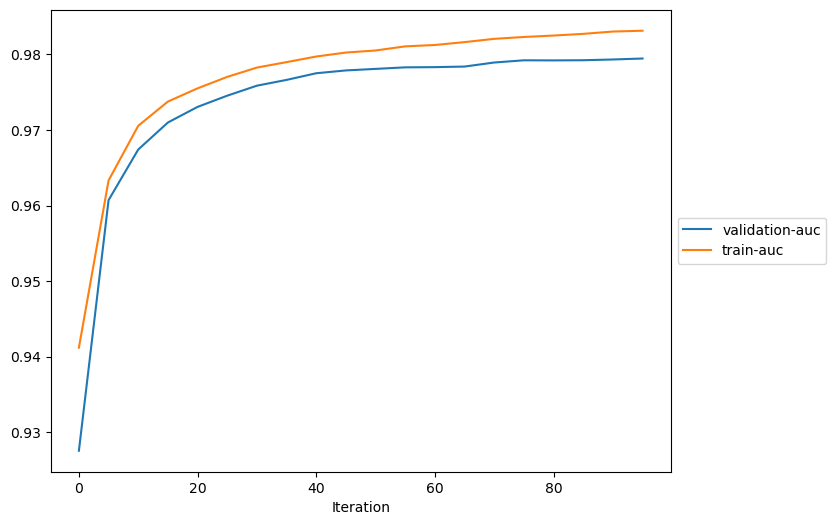

In [30]:
plot_collection(trial, "metrics")

In [31]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

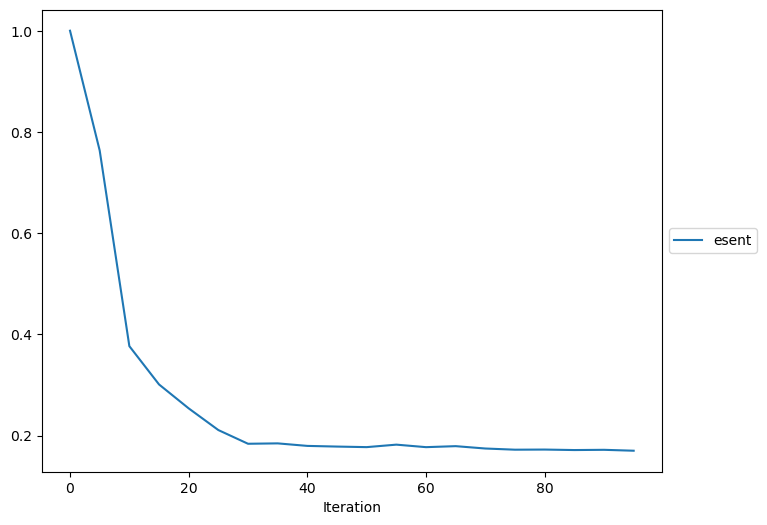

In [32]:
plot_feature_importance(trial, importance_type="cover")

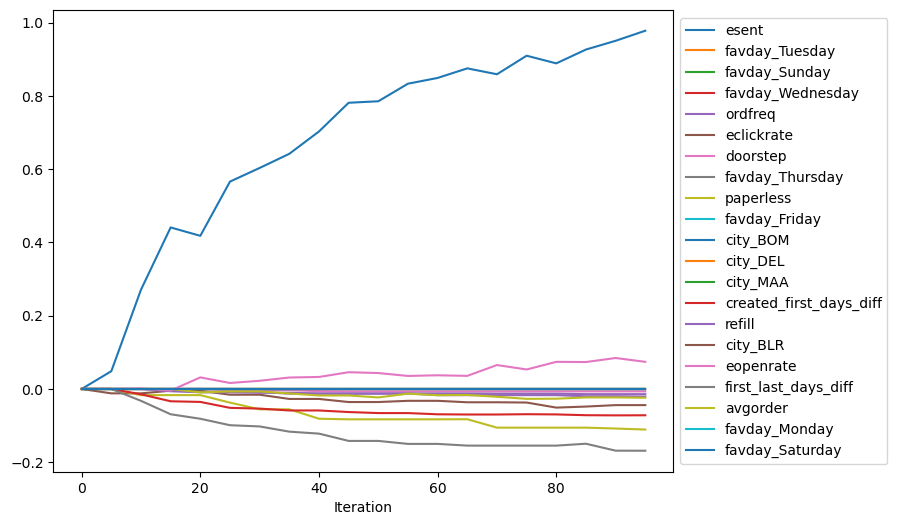

In [33]:
plot_collection(trial, "average_shap")

# Global Explanations

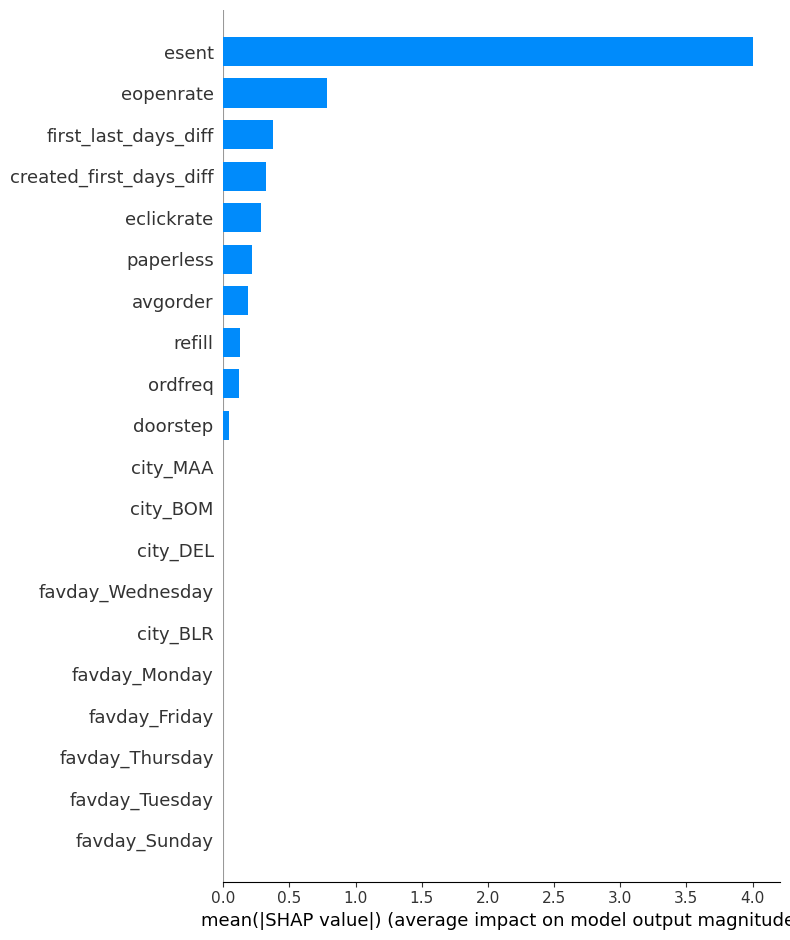

In [34]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [35]:
shap_base_value

2.0644114

In [36]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)

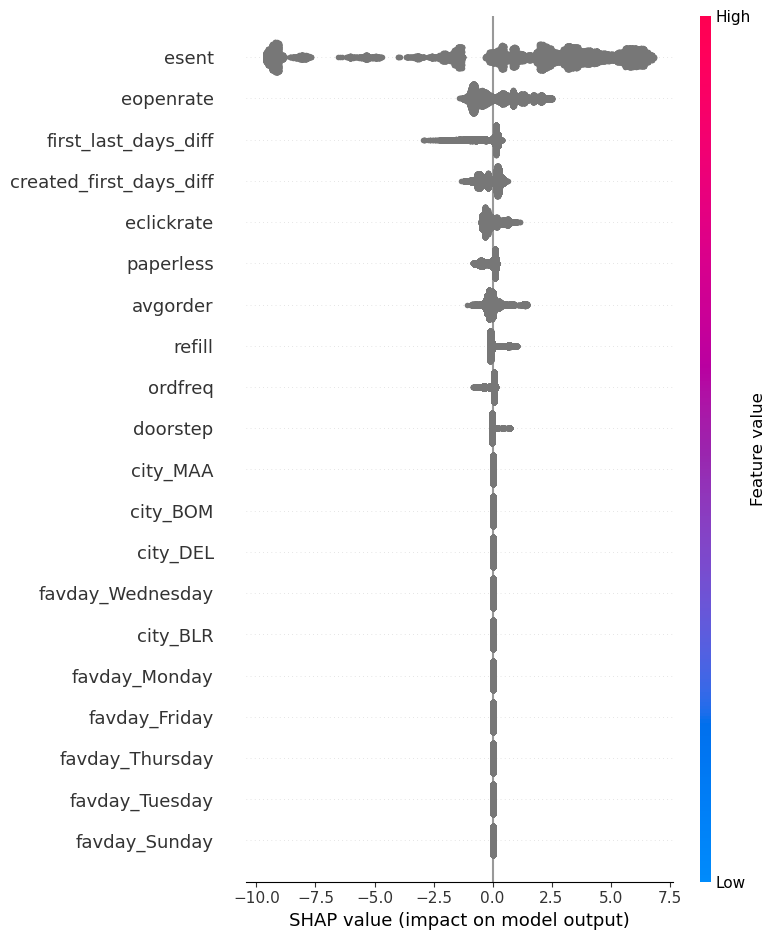

In [37]:
shap.summary_plot(shap_no_base, train_shap)